# **LSTM for dynamic and static data**

We have previously built and trained an LSTM model for binary classification of extubation failure on purely dynamic (time-series) data.

Hoewver, in the ICU, dynamic data is not the only type of data available. Static data is frequently collected and could influence decisions made my clinicians around extubation.

As such, we will develop and train an LSTM model that can take in both static and dynamic data and predict extubation failure.

This will, for all intense and purposes, be similar to the design of the simple LSTM model created previosuly but with an extra layer required to handle static data.

The design of this model is influenced by the paper by Esteban et al. (https://arxiv.org/pdf/1602.02685), where a Combined Model is created with a Linear, fully-connected layer used to handle the static data. The outputs of the static and LSTM layer are then concatenated and passed into the output layer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class TimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with combined static and dynamic features.

    Args:
        sequences (numpy.ndarray): A NumPy array containing time series sequences.
        static_features (numpy.ndarray): A NumPy array containing static features for each sequence.
        labels (numpy.ndarray): A NumPy array containing the corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the time series sequence, static features, and label for the given index.
    """
    def __init__(self, sequences, static_features, labels):
        self.sequences = sequences
        self.static_features = static_features
        self.labels = labels

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Returns a dictionary containing the time series sequence, static features, and label for the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary with keys 'sequence', 'static', and 'label', containing the time series sequence, static features, and label tensors, respectively.
        """
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'static': torch.tensor(self.static_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }


In [ ]:
def create_data_loaders(train_sequences, train_static, train_labels, val_sequences, val_static, val_labels, test_sequences, test_static, test_labels, batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and test sets.

    Args:
        train_sequences: Training sequences.
        train_static: Training static features.
        train_labels: Training labels.
        val_sequences: Validation sequences.
        val_static: Validation static features.
        val_labels: Validation labels.
        test_sequences: Test sequences.
        test_static: Test static features.
        test_labels: Test labels.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing the train, validation, and test DataLoaders.
    """
    train_dataset = TimeSeriesDataset(train_sequences, train_static, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_static, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_static, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Data sampling**

Under, Over and Normal sampling

In [ ]:
def undersample_data(sequences, static, labels):
    """
    Undersamples the data using RandomUnderSampler.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Undersampled sequences, static features, and labels.
    """
    rus = RandomUnderSampler()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    combined_features = np.hstack((sequences_flat, static))
    combined_resampled, labels_resampled = rus.fit_resample(combined_features, labels)
    sequences_resampled = combined_resampled[:, :sequences_flat.shape[1]].reshape((-1, sequences.shape[1], sequences.shape[2]))
    static_resampled = combined_resampled[:, sequences_flat.shape[1]:]
    return sequences_resampled, static_resampled, labels_resampled

In [ ]:
def oversample_data(sequences, static, labels):
    """
    Oversamples the data using SMOTE.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Oversampled sequences, static features, and labels.
    """
    smote = SMOTE()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    combined_features = np.hstack((sequences_flat, static))
    combined_resampled, labels_resampled = smote.fit_resample(combined_features, labels)
    sequences_resampled = combined_resampled[:, :sequences_flat.shape[1]].reshape((-1, sequences.shape[1], sequences.shape[2]))
    static_resampled = combined_resampled[:, sequences_flat.shape[1]:]
    return sequences_resampled, static_resampled, labels_resampled

Define the LSTM model

In [ ]:
class LSTMModel(nn.Module):
    """
    A LSTM model that combines static and dynamic information for binary classification.

    Args:
        input_dim (int): The number of features in the input sequence (dynamic).
        static_dim (int): The number of static features.
        hidden_dim (int): The number of features in the hidden state of the LSTM.
        layer_dim (int): The number of LSTM layers.
        output_dim (int): The number of output classes (1 for binary classification).
        dropout_prob (float): The dropout probability.

    Methods:
        forward(x, static): Defines the forward pass of the model.
    """
    def __init__(self, input_dim, static_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Dropout requires > 1 layer
        if layer_dim == 1:
            dropout_prob = 0

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)  # LSTM layer for dynamic features
        self.fc_static = nn.Linear(static_dim, hidden_dim)  # Fully connected layer for static features
        self.fc_combined = nn.Linear(hidden_dim * 2, output_dim)  # Fully connected layer for combined features
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, static):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_dim).
            static (torch.Tensor): The static features tensor of shape (batch_size, static_dim).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, output_dim).
        """
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take the last output of the LSTM

        static_out = self.fc_static(static)
        static_out = self.dropout(static_out)
        combined_out = torch.cat((out, static_out), dim=1)  # Concatenate the LSTM output and static features

        out = self.fc_combined(combined_out)
        out = self.sigmoid(out)
        return out


In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after last time validation loss improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        """
        Checks the validation AUC and decides whether to stop training.

        Args:
            val_auc (float): Validation AUC score.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

**Model training function**

In [ ]:
def train_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the model with early stopping and logging.

    Parameters:
    model (nn.Module): The LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    # Initialize early stopping and checkpoint utilities
    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)  # Min delta set to 0 so any improvement in AUC resets patience counter

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(sequences, static)  # Forward pass

            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            running_loss += loss.item() * sequences.size(0)  # Accumulate loss

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                sequences = data['sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
                outputs = model(sequences, static)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                val_running_loss += loss.item() * sequences.size(0)  # Accumulate loss
                val_outputs.extend(outputs.cpu().numpy())  # Collect outputs
                val_labels.extend(labels.cpu().numpy())  # Collect labels

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)  # Check for early stopping

        # Check for best performing model
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs


**Cross validation function**

In [ ]:
def shuffle_data(sequences, static, labels):
    """
    Shuffles the sequences, static features, and labels in unison.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Shuffled sequences, static features, and labels.
    """
    assert len(sequences) == len(static) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], static[p], labels[p]

In [ ]:
def split_data_into_folds(sequences, static, labels, num_folds):
    """
    Splits the data into the specified number of folds for cross-validation.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.
        num_folds (int): Number of folds for cross-validation.

    Returns:
        tuple: Lists of sequences, static features, and labels split into folds.
    """
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    static_folds = []
    labels_folds = []

    for i in range(num_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i != num_folds - 1 else len(sequences)
        sequences_folds.append(sequences[start:end])
        static_folds.append(static[start:end])
        labels_folds.append(labels[start:end])

    return sequences_folds, static_folds, labels_folds

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def manual_cross_validation(sequences, static, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    """
    Performs manual cross-validation.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.
        hyperparameters (list): List of hyperparameter dictionaries to test.
        num_folds (int): Number of folds for cross-validation.
        patience (int): Patience for early stopping.
        output_path (str): Path to save the best model checkpoint.

    Returns:
        tuple: Best model, best hyperparameters, and best AUC score.
    """
    # Shuffle and split the data
    sequences, static, labels = shuffle_data(sequences, static, labels)
    sequences_folds, static_folds, labels_folds = split_data_into_folds(sequences, static, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        # Separate into train and validation sets
        val_sequences = sequences_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods - do not change the validation data
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
            else:
                train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels


            # # Debugging: Check data distributions and shapes
            # print(f"Static data mean: {np.mean(train_static, axis=0)}")
            # print(f"Static data std: {np.std(train_static, axis=0)}")

            # # Print shapes after resampling
            # print(f"Train sequences resampled shape: {train_sequences_resampled.shape}")
            # print(f"Train static resampled shape: {train_static_resampled.shape}")
            # print(f"Train labels resampled shape: {train_labels_resampled.shape}")


            # Create data loaders
            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_static_resampled, train_labels_resampled,
                val_sequences, val_static, val_labels,
                val_sequences, val_static, val_labels,
                batch_size=params['batch_size']
            )


            # # Print shapes after creating data loaders
            # print(f"Train sequences shape: {train_sequences.shape}")
            # print(f"Train static shape: {train_static.shape}")
            # print(f"Train labels shape: {train_labels.shape}")


            # Initialize the model
            model = LSTMModel(
                input_dim=train_sequences.shape[2],
                static_dim=train_static.shape[1],
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob'],
            ).to(device)

            # Reset the model weights
            reset_model(model)

            # Define the cross-entropy loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
                    outputs = model(sequences, static)

                    val_outputs.extend(outputs.cpu().numpy().flatten())  # Flatten the output
                    val_labels.extend(labels.cpu().numpy().flatten())  # Flatten the labels

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc


**Training the final model**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Extract dynamic and static data and labels
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences, static)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, train_losses


**Model evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences, static)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

**Results analysis**

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def analyze_class_distribution(labels):
    """
    Analyze the class distribution of the labels.

    Parameters:
    labels (np.array): 1D numpy array of labels.

    Returns:
    dict: A dictionary containing the count of each class.
    """
    # Count the occurrences of each class
    class_counts = Counter(labels)

    return class_counts

def plot_class_distribution(class_counts):
    """
    Plot the class distribution.

    Parameters:
    class_counts (dict): A dictionary containing the count of each class.
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences, static)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)


In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Success', 'Failure']  # Replace with your actual class names if different

**Model interpretability**

In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences, static)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

def feature_ablation_with_names(train_sequences, train_static, train_labels, test_sequences, test_static, test_labels, model, best_hyperparams, device, feature_names_dynamic, feature_names_static):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_static (np.array): The training static features.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained LSTM model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    feature_names_dynamic (list): List of dynamic feature names.
    feature_names_static (list): List of static feature names.

    Returns:
    pd.DataFrame: DataFrame containing the feature importances.
    """
    def evaluate_model_ablation(model, data_loader, criterion, device):
        model.eval()
        all_labels = []
        all_outputs = []
        total_loss = 0.0

        with torch.no_grad():
            for data in data_loader:
                sequences = data['sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

                outputs = model(sequences, static)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * sequences.size(0)

                all_outputs.extend(outputs.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())

        avg_loss = total_loss / len(data_loader.dataset)
        accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        roc_auc = roc_auc_score(all_labels, all_outputs)
        specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

        return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

    feature_importances = defaultdict(dict)
    input_dim_dynamic = train_sequences.shape[2]
    input_dim_static = train_static.shape[1]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_static, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Ablation for dynamic features
    for feature_idx in range(input_dim_dynamic):
        feature_name = feature_names_dynamic[feature_idx]
        print(f"Ablating dynamic feature {feature_name} ({feature_idx + 1}/{input_dim_dynamic})")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_static, train_labels,
            train_sequences_ablation, train_static, train_labels,
            test_sequences_ablation, test_static, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = LSTMModel(
            input_dim=train_sequences_ablation.shape[2],
            static_dim=input_dim_static,
            hidden_dim=best_hyperparams['hidden_dim'],
            layer_dim=best_hyperparams['layer_dim'],
            output_dim=1,
            dropout_prob=best_hyperparams['dropout_prob']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['dynamic'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for static features
    for feature_idx in range(input_dim_static):
        feature_name = feature_names_static[feature_idx]
        print(f"Ablating static feature {feature_name} ({feature_idx + 1}/{input_dim_static})")

        # Remove the feature from the static data
        train_static_ablation = np.delete(train_static, feature_idx, axis=1)
        test_static_ablation = np.delete(test_static, feature_idx, axis=1)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences, train_static_ablation, train_labels,
            train_sequences, train_static_ablation, train_labels,
            test_sequences, test_static_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = LSTMModel(
            input_dim=input_dim_dynamic,
            static_dim=train_static_ablation.shape[1],
            hidden_dim=best_hyperparams['hidden_dim'],
            layer_dim=best_hyperparams['layer_dim'],
            output_dim=1,
            dropout_prob=best_hyperparams['dropout_prob']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['static'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Combine feature importances for plotting
    combined_feature_importances = {**feature_importances['dynamic'], **feature_importances['static']}

    # Convert feature importances to DataFrames for better readability
    dynamic_importances_df = pd.DataFrame.from_dict(feature_importances['dynamic'], orient='index').sort_values(by='roc_auc', ascending=False)
    static_importances_df = pd.DataFrame.from_dict(feature_importances['static'], orient='index').sort_values(by='roc_auc', ascending=False)
    combined_importances_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index').sort_values(by='roc_auc', ascending=False)

    # Plot dynamic feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(dynamic_importances_df.index, dynamic_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Dynamic Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(static_importances_df.index, static_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot combined feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(combined_importances_df.index, combined_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Combined Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return combined_importances_df


# **Experiment 1**

### **Bayesian optimisation**




In [ ]:
import itertools

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.6 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective_wrapper(train_sequences, train_static, train_labels):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
        layer_dim = trial.suggest_categorical('layer_dim', [1, 2, 3, 4])
        dropout_prob = trial.suggest_categorical('dropout_prob', [0.0, 0.25, 0.5, 0.75])
        learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
        num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
        sampling_method = trial.suggest_categorical('sampling_method', ['normal', 'undersample', 'oversample'])
        loss = trial.suggest_categorical('loss', ['normal', 'weighted'])
        weight_decay = trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3, 1e-2])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_static,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

# **Extract dynamic and static train and test sets**

In [ ]:
# Load the train and test sequences
train_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_sequences_v3.npy'
train_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_labels_v3.npy'
test_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_sequences_v3.npy'
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_labels_v3.npy'

train_sequences = np.load(train_sequences_path, allow_pickle=True).astype(np.float32)
train_labels = np.load(train_labels_path, allow_pickle=True).astype(np.float32)
test_sequences = np.load(test_sequences_path, allow_pickle=True).astype(np.float32)
test_labels = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train sequences shape: {train_sequences.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train sequences shape: (3760, 13, 12)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 12)
Test labels shape: (941,)


In [ ]:
# Extract the static data
train_static_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_sequences.npy'
test_static_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_static_sequences.npy'

train_static = np.load(train_static_sequences_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_sequences_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 13, 36)
Test static shape: (941, 13, 36)


This static data essentially mimics the time series spread of the dynamic data. To use this data we would need to concatenate this data with the dynamic data and run that all through an LSTM layer rather than running the static data through a Linear layer separately.

# **Practice running the model on dummy data to see if it runs**

In [ ]:
# Generate dummy data
# Parameters for dummy data
num_samples = 500
sequence_length = 10
num_sequence_features = 5
num_static_features = 37

# Generate random sequences data
dummy_train_sequences = np.random.randn(num_samples, sequence_length, num_sequence_features)

# Generate random static features data
dummy_train_static = np.random.randn(num_samples, num_static_features)

# Generate random binary labels
dummy_train_labels = np.random.randint(0, 2, num_samples)

In [ ]:
print(dummy_train_sequences.shape)
print(dummy_train_static.shape)
print(dummy_train_labels.shape)

(500, 10, 5)
(500, 37)
(500,)


In [ ]:
dummy_hyperparameters = [
    {
        'hidden_dim': 64,
        'layer_dim': 2,
        'dropout_prob': 0.3,
        'learning_rate': 0.001,
        'batch_size': 32,
        'num_epochs': 20,
        'sampling_method': 'normal',  # Can be 'normal', 'undersample', or 'oversample'
        'loss': 'normal',             # Can be 'normal' or 'weighted'
        'weight_decay': 1e-5
    }
]

Epoch 0/19, Loss: 0.6945, Val Loss: 0.7031, Val AUC: 0.4784
Epoch 1/19, Loss: 0.6808, Val Loss: 0.7019, Val AUC: 0.4844
Epoch 2/19, Loss: 0.6839, Val Loss: 0.7042, Val AUC: 0.4856
Epoch 3/19, Loss: 0.6748, Val Loss: 0.7038, Val AUC: 0.4944
Epoch 4/19, Loss: 0.6701, Val Loss: 0.7040, Val AUC: 0.4972
Epoch 5/19, Loss: 0.6729, Val Loss: 0.7039, Val AUC: 0.5084
Epoch 6/19, Loss: 0.6591, Val Loss: 0.7084, Val AUC: 0.5076
Epoch 7/19, Loss: 0.6621, Val Loss: 0.7099, Val AUC: 0.5116
Epoch 8/19, Loss: 0.6680, Val Loss: 0.7142, Val AUC: 0.5040
Epoch 9/19, Loss: 0.6559, Val Loss: 0.7233, Val AUC: 0.4956
Epoch 10/19, Loss: 0.6547, Val Loss: 0.7225, Val AUC: 0.5004
Epoch 11/19, Loss: 0.6497, Val Loss: 0.7227, Val AUC: 0.5004
Epoch 12/19, Loss: 0.6466, Val Loss: 0.7263, Val AUC: 0.5044
Early stopping
Params: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05}, Val AUC

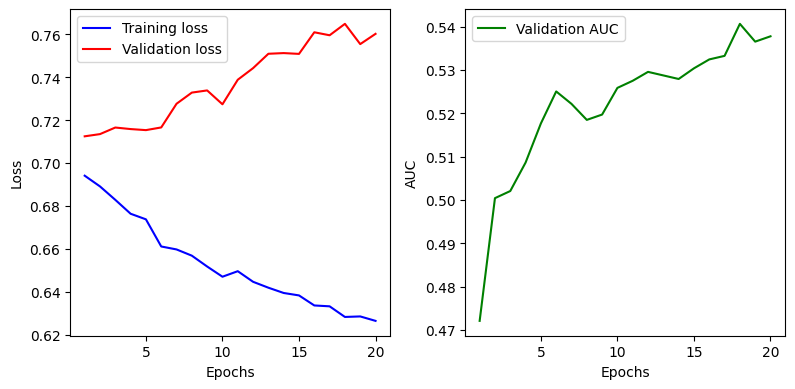

Best hyperparameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05}
Best AUC: 0.5377668308702792


In [ ]:
# Run the cross validation on dummy data
dummy_model, dummy_hyperparams, dummy_auc = manual_cross_validation(
    dummy_train_sequences,
    dummy_train_static,
    dummy_train_labels,
    dummy_hyperparameters,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {dummy_hyperparams}")
print(f"Best AUC: {dummy_auc}")

# **Experiment 1 - Hyperparameter tuning with Bayesian Optimisation**

In [ ]:
param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_combinations = list(itertools.product(*param_grid.values()))

param_combinations = [
    dict(zip(param_grid.keys(), params))
    for params in param_combinations
]

print(f"Total hyperparameter combinations: {len(param_combinations)}")

Total hyperparameter combinations: 153600


In [ ]:
import json

In [ ]:
# Run Bayesian Hyperparameter optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective_wrapper(train_sequences, train_static, train_labels), n_trials=10)

best_hyperparams = study.best_params
best_auc = study.best_value

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best AUC: {best_auc}")

[I 2024-07-19 23:49:34,299] A new study created in memory with name: no-name-72e863aa-b0ac-438a-8b34-c09a43ea24f8
[I 2024-07-19 23:49:34,304] Trial 0 pruned. 


Static data mean: [1.39675332e+07 4.55162340e-01 5.07623192e-01 3.48001790e-01
 2.29388298e-01 2.46010638e-01 1.17686170e-01 2.77925532e-01
 5.77460106e-01 9.30851064e-03 2.32712766e-03 9.97340426e-03
 6.64893617e-04 2.65957447e-03 4.65425532e-03 8.47739362e-02
 6.64893617e-03 5.31914894e-03 7.64627660e-03 3.32446809e-04
 6.64893617e-04 1.03058511e-02 3.32446809e-03 6.64893617e-04
 3.32446809e-04 1.06382979e-02 6.64893617e-04 0.00000000e+00
 1.99468085e-03 1.97473404e-01 6.31648936e-03 6.64893617e-04
 6.04388298e-01 1.66223404e-03 2.99202128e-03 1.32978723e-02
 5.98404255e-03]
Static data std: [2.30136336e+06 1.85699447e-01 1.90994533e-01 1.36952794e-01
 4.20439421e-01 4.30684808e-01 3.22236149e-01 4.47976484e-01
 4.93963492e-01 9.60305278e-02 4.81841482e-02 9.93676782e-02
 2.57769574e-02 5.15024381e-02 6.80631562e-02 2.78544998e-01
 8.12694765e-02 7.27382677e-02 8.71080424e-02 1.82300929e-02
 2.57769574e-02 1.00993270e-01 5.75622793e-02 2.57769574e-02
 1.82300929e-02 1.02592029e-01 2.

[W 2024-07-19 23:49:38,585] Trial 1 failed with parameters: {'hidden_dim': 256, 'layer_dim': 3, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.01} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-17-6046b6ff9636>", line 30, in objective
    best_model, best_hyperparams, best_auc = manual_cross_validation(
  File "<ipython-input-28-607c6033c287>", line 97, in manual_cross_validation
    model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
  File "<ipython-input-10-67538ec2ae51>", line 45, in train_model_with_early_stopping_logging
    loss = criterion(outputs, labels)  # Compute the loss
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.

Epoch 21/29, Loss: 49.8474, Val Loss: 66.3564, Val AUC: 0.5000


KeyboardInterrupt: 

## **Data debugging**
In the static data one of the values has an extremely high mean (1.39675332e+07) which would indicate an unnormalised feature.

Let's try and debug and see.

In [ ]:
np.mean(train_static, axis=0)

array([1.39753567e+07, 4.57754113e-01, 5.07896693e-01, 3.49669693e-01,
       2.23936170e-01, 2.46808511e-01, 1.19414894e-01, 2.77659574e-01,
       5.77393617e-01, 9.57446809e-03, 2.39361702e-03, 1.01063830e-02,
       5.31914894e-04, 2.65957447e-03, 3.98936170e-03, 8.59042553e-02,
       6.11702128e-03, 5.58510638e-03, 7.18085106e-03, 2.65957447e-04,
       5.31914894e-04, 9.84042553e-03, 3.19148936e-03, 7.97872340e-04,
       5.31914894e-04, 1.11702128e-02, 7.97872340e-04, 2.65957447e-04,
       2.39361702e-03, 1.96808511e-01, 5.85106383e-03, 7.97872340e-04,
       6.04787234e-01, 1.32978723e-03, 2.39361702e-03, 1.40957447e-02,
       6.11702128e-03])

In [ ]:
# Convert train_static to pd
train_static_df = pd.DataFrame(train_static)
train_static_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,10001884.0,0.305322,0.250000,0.309554,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10002428.0,0.099907,0.104167,0.160855,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10004235.0,0.884220,0.791667,0.546203,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10004720.0,0.352007,0.791667,0.197548,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,10004733.0,0.748833,0.729167,0.480639,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is not recognisable data.

Let's load the data from npy files.

In [ ]:
# Load npy train static data
train_static_npy = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/t

# **Solution: Properly save the static combined data into npy and reload and train again **

# **Experiment 2**

Data is now the re-preprocessed dynamic data and static data.

We will align the subject_ids from the dynamic data to the static data to ensure that patients are in the same order for the model to read.



In [ ]:
# Load the train and test sequences
train_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_sequences_v3.npy'
train_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_labels_v3.npy'
test_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_sequences_v3.npy'
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_labels_v3.npy'

train_sequences = np.load(train_sequences_path, allow_pickle=True).astype(np.float32)
train_labels = np.load(train_labels_path, allow_pickle=True).astype(np.float32)
test_sequences = np.load(test_sequences_path, allow_pickle=True).astype(np.float32)
test_labels = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train sequences shape: {train_sequences.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train sequences shape: (3760, 13, 12)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 12)
Test labels shape: (941,)


In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_combined_v2.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_combined_v2.npy'

train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 37)
Test static shape: (941, 37)


In [ ]:
# Load the train and test subject id order from the dynamic data
train_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_subject_ids_v3.npy'
test_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_subject_ids_v3.npy'

train_subject_id_order = np.load(train_subject_id_order_path, allow_pickle=True).astype(np.float32)
test_subject_id_order = np.load(test_subject_id_order_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train subject id order shape: {train_subject_id_order.shape}")
print(f"Test subject id order shape: {test_subject_id_order.shape}")

Train subject id order shape: (3760,)
Test subject id order shape: (941,)


In [ ]:
train_subject_id_order[:5]

array([10001884., 10002428., 10004235., 10010867., 10011365.],
      dtype=float32)

In [ ]:
train_static_copy = train_static.copy()
test_static_copy = test_static.copy()

In [ ]:
# Order the rows in the static data to match the dynamic subject id order

# Create a dictionary mapping from subject_id to static features
static_data_dict = {row[0]: row[1:] for row in train_static}

# Reorder static data to match the order of train_subject_id_order
train_static = np.array([static_data_dict[subject_id] for subject_id in train_subject_id_order])

print(f"Train static shape: {train_static.shape}")

Train static shape: (3760, 36)


In [ ]:
# See the first 5 keys in the dict
list(static_data_dict.keys())[:5]

[10001884.0, 10002428.0, 10004235.0, 10010867.0, 10011365.0]

In [ ]:
# Look at the columns in the static data
train_static_df = pd.DataFrame(train_static)
train_static_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Look at the mean values
np.mean(train_static, axis=0)

array([4.5861742e-01, 5.0772172e-01, 3.7978122e-01, 2.2101064e-01,
       2.5106382e-01, 1.1914894e-01, 2.7446809e-01, 5.7313830e-01,
       1.0372341e-02, 2.1276595e-03, 7.7127661e-03, 1.0638298e-03,
       3.1914893e-03, 3.4574468e-03, 8.2446806e-02, 7.1808510e-03,
       5.3191488e-03, 9.5744682e-03, 2.6595744e-04, 5.3191488e-04,
       9.8404251e-03, 2.6595744e-03, 1.0638298e-03, 5.3191488e-04,
       1.1170213e-02, 1.0638298e-03, 5.3191488e-04, 2.1276595e-03,
       1.9015957e-01, 5.0531914e-03, 1.0638298e-03, 6.1196810e-01,
       1.5957446e-03, 2.3936171e-03, 1.6489362e-02, 5.5851066e-03],
      dtype=float32)

Apply the same logic to the test data

In [ ]:
test_static_data_dict = {row[0]: row[1:] for row in test_static}

# Reorder static data to match the order of test_subject_id_order
test_static = np.array([test_static_data_dict[subject_id] for subject_id in test_subject_id_order])

print(f"Test static shape: {test_static.shape}")

Test static shape: (941, 36)


The mean values are all in a similar range and the subject id column has been removed.

We can now proceed to training the model.

### **Experiment 2 - Hyperparameter tuning**

In [ ]:
study_exp_2 = optuna.create_study(direction='minimize')
study_exp_2.optimize(objective_wrapper(train_sequences, train_static, train_labels), n_trials=100)

best_hyperparams_exp_2 = study_exp_2.best_params
best_score = study_exp_2.best_value

# Save the best params in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/static_and_dynamic_best_models/experiment_2/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_exp_2, f)

print(f"Best hyperparameters: {best_hyperparams_exp_2}")
print(f"Best AUC: {best_score}")

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 128, 'layer_dim': 3, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.01}

Best AUC: -0.7023960653748195


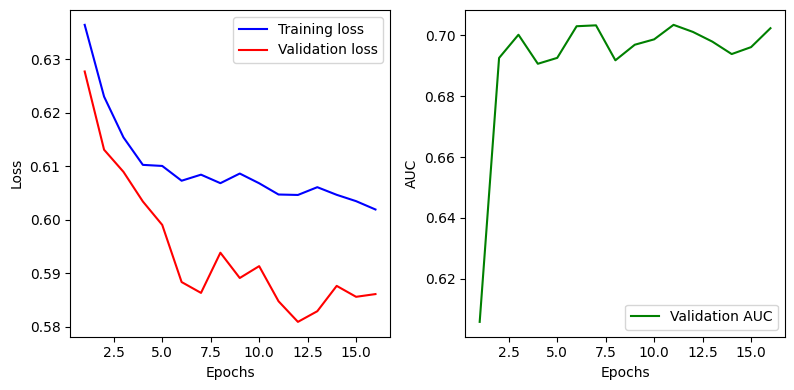

In [ ]:
best_hyperparams_exp_2

{'hidden_dim': 128,
 'layer_dim': 3,
 'dropout_prob': 0.25,
 'learning_rate': 0.001,
 'batch_size': 32,
 'num_epochs': 40,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 0.01}

### **Experiment 2 - Train model with best params on full training set**

In [ ]:
final_model = LSTMModel(
    input_dim=train_sequences.shape[2],
    static_dim=train_static.shape[1],
    hidden_dim=best_hyperparams_exp_2['hidden_dim'],
    layer_dim=best_hyperparams_exp_2['layer_dim'],
    output_dim=1,
    dropout_prob=best_hyperparams_exp_2['dropout_prob'],
).to(device)

In [ ]:
# Handle sampling methods
if best_hyperparams_exp_2['sampling_method'] == 'undersample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
elif best_hyperparams_exp_2['sampling_method'] == 'oversample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
else:
  train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels

# Define the loss function
if best_hyperparams_exp_2['loss'] == 'weighted':
  pos_weight = torch.tensor([best_hyperparams_exp_2['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_hyperparams_exp_2['learning_rate'],
    weight_decay=best_hyperparams_exp_2['weight_decay']
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
train_loader, _, test_loader = create_data_loaders(
    train_sequences_resampled, train_static_resampled, train_labels_resampled,
    _, _, _,
    test_sequences, test_static, test_labels,
    batch_size=best_hyperparams_exp_2['batch_size']
)

In [ ]:
reset_model(final_model)

In [ ]:
# Train the model on the full training data
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    best_hyperparams_exp_2['num_epochs'],
    device
)

Epoch 1/40, Loss: 0.6397
Epoch 2/40, Loss: 0.6320
Epoch 3/40, Loss: 0.6321
Epoch 4/40, Loss: 0.6306
Epoch 5/40, Loss: 0.6297
Epoch 6/40, Loss: 0.6311
Epoch 7/40, Loss: 0.6298
Epoch 8/40, Loss: 0.6285
Epoch 9/40, Loss: 0.6295
Epoch 10/40, Loss: 0.6296
Epoch 11/40, Loss: 0.6291
Epoch 12/40, Loss: 0.6304
Epoch 13/40, Loss: 0.6294
Epoch 14/40, Loss: 0.6295
Epoch 15/40, Loss: 0.6290
Epoch 16/40, Loss: 0.6291
Epoch 17/40, Loss: 0.6297
Epoch 18/40, Loss: 0.6288
Epoch 19/40, Loss: 0.6292
Epoch 20/40, Loss: 0.6292
Epoch 21/40, Loss: 0.6296
Epoch 22/40, Loss: 0.6290
Epoch 23/40, Loss: 0.6297
Epoch 24/40, Loss: 0.6283
Epoch 25/40, Loss: 0.6288
Epoch 26/40, Loss: 0.6288
Epoch 27/40, Loss: 0.6292
Epoch 28/40, Loss: 0.6293
Epoch 29/40, Loss: 0.6282
Epoch 30/40, Loss: 0.6295
Epoch 31/40, Loss: 0.6299
Epoch 32/40, Loss: 0.6296
Epoch 33/40, Loss: 0.6290
Epoch 34/40, Loss: 0.6292
Epoch 35/40, Loss: 0.6285
Epoch 36/40, Loss: 0.6286
Epoch 37/40, Loss: 0.6291
Epoch 38/40, Loss: 0.6281
Epoch 39/40, Loss: 0.

In [ ]:
import pickle

In [ ]:
# Save the final model
final_model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/static_and_dynamic_best_models/experiment_2/final_model.pkl'
with open(final_model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate the final model**

In [ ]:
test_static.shape

(941, 36)

In [ ]:
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6716
Precision: 0.0000
Recall (Sensitivity): 0.0000
F1 Score: 0.0000
ROC AUC: 0.5605
Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6716259298618491, 0.0, 0.0, 0.0, 0.5604645446724837, 1.0)

Accuracy: 0.6716
Precision: 0.0000
Recall (Sensitivity): 0.0000
F1 Score: 0.0000
ROC AUC: 0.5605
Specificity: 1.0000

With precision and recall being 0 - this indicates that all results are being predicted as the negative class i.e. extubation success.

This could be due to:
- class imbalance
- model training issues
- evaluation threshold

Plot ROC curve

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(model, test_sequences, test_static, test_labels, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_sequences (numpy.array): The test sequences data.
    test_static (numpy.array): The test static data.
    test_labels (numpy.array): The true labels for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """

    # Ensure test_sequences and test_static are numpy arrays and then convert them to PyTorch tensors
    test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    test_static_tensor = torch.tensor(test_static, dtype=torch.float32).to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        predictions = model(test_sequences_tensor, test_static_tensor)

    # Extract predictions as a numpy array
    predictions_np = predictions.cpu().numpy().flatten()

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions_np)

    # Plot ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


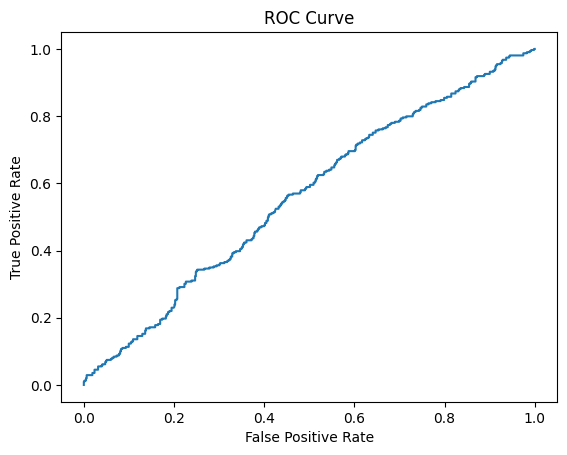

In [ ]:
plot_roc_curve(final_model, test_sequences, test_static, test_labels, device)

**Analysis of predictions**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def analyze_class_distribution(labels):
    """
    Analyze the class distribution of the labels.

    Parameters:
    labels (np.array): 1D numpy array of labels.

    Returns:
    dict: A dictionary containing the count of each class.
    """
    class_counts = Counter(labels)
    return class_counts

def plot_class_distribution(class_counts, title):
    """
    Plot the class distribution.

    Parameters:
    class_counts (dict): A dictionary containing the count of each class.
    title (str): Title for the plot.
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()


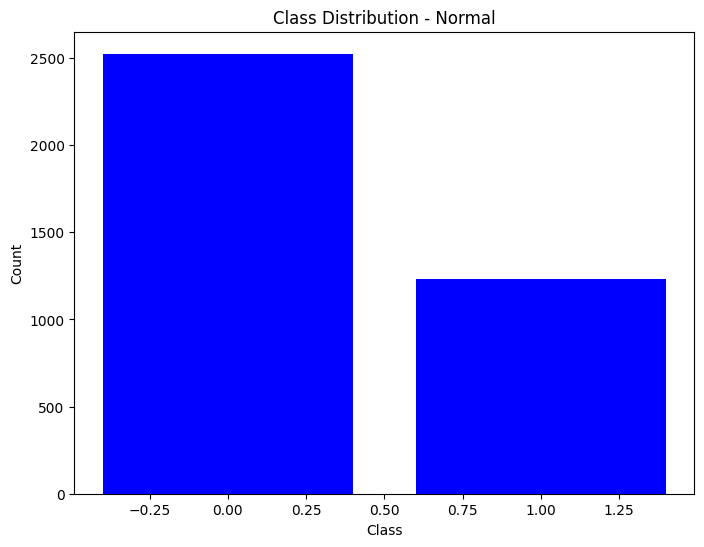

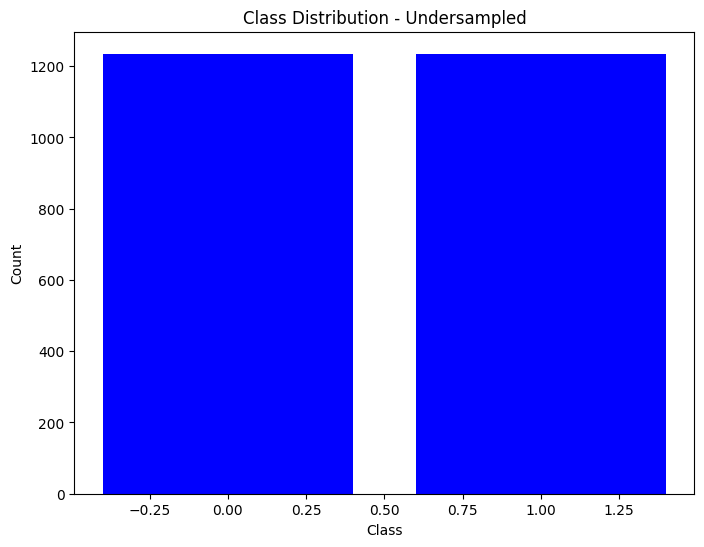

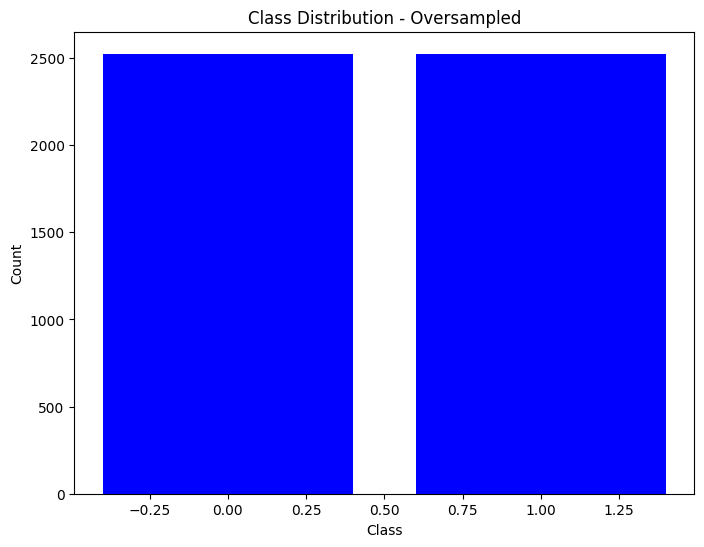

In [ ]:
# Analyze and plot class distribution for normal data
normal_class_counts = analyze_class_distribution(train_labels)
plot_class_distribution(normal_class_counts, 'Class Distribution - Normal')

# Apply undersampling
under_sequences, under_static, under_labels = undersample_data(train_sequences, train_static, train_labels)
under_class_counts = analyze_class_distribution(under_labels)
plot_class_distribution(under_class_counts, 'Class Distribution - Undersampled')

# Apply oversampling
over_sequences, over_static, over_labels = oversample_data(train_sequences, train_static, train_labels)
over_class_counts = analyze_class_distribution(over_labels)
plot_class_distribution(over_class_counts, 'Class Distribution - Oversampled')

In [ ]:
print(normal_class_counts)
print(under_class_counts)
print(over_class_counts)

Counter({0.0: 2525, 1.0: 1235})
Counter({0.0: 1235, 1.0: 1235})
Counter({1.0: 2525, 0.0: 2525})


The class imbalance / balancing is as expected.

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

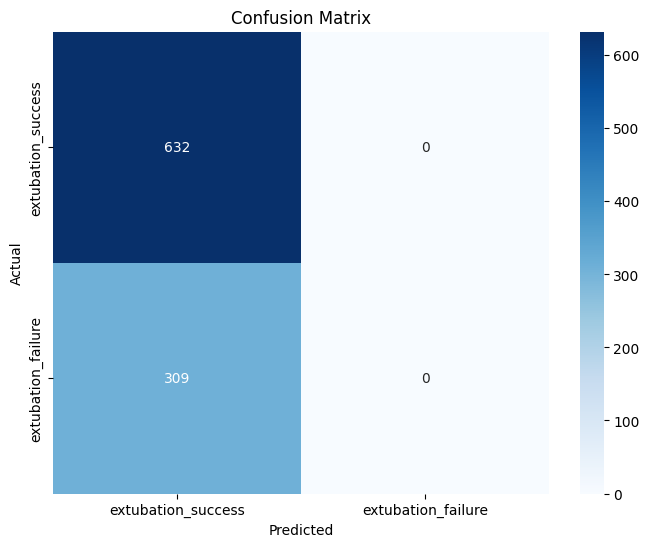

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
class_names = ['extubation_success', 'extubation_failure']
plot_confusion_matrix(cm, class_names)

**Classification threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

def find_best_threshold_roc_auc(model, test_sequences, test_static, test_labels, device):
    """
    Find the best classification threshold based on the ROC AUC score and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The true labels for the test data.
    device (torch.device): The device to run the model on.

    Returns:
    float: The best classification threshold.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_sequences)):
            sequence = test_sequences[i]
            static = test_static[i]
            label = test_labels[i]

            # Convert sequence and static features to torch tensors
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)
            static_tensor = torch.tensor(static, dtype=torch.float32).unsqueeze(0).to(device)

            # Get model output (predicted probabilities)
            output = model(sequence_tensor, static_tensor)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend([label])

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Find the best threshold based on the ROC AUC score
    best_roc_auc = 0
    best_threshold = 0
    for threshold in thresholds:
        predictions = (all_probs >= threshold).astype(int)
        roc_auc = roc_auc_score(all_labels, predictions)
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_threshold = threshold

    # Final predictions using the best threshold
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    print(f"Best threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return best_threshold

In [ ]:
best_threshold = find_best_threshold_roc_auc(final_model, test_sequences, test_static, test_labels, device)

Best threshold: 0.3433
Accuracy: 0.5526
Precision: 0.3788
Recall: 0.5663
F1 Score: 0.4540
ROC AUC: 0.5605
Specificity: 0.5459


The ideal threshold is 0.34 rather than 0.5.

### **Experiment 2 - Model Interpretability**

We can now run our feature ablation study to see the importance of each feature in the model decision making.

In [ ]:
# Get the feature names
dynamic_feature_names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/feature_names_v3.npy'
dynamic_feature_names = np.load(dynamic_feature_names_path, allow_pickle=True)

# Print the shape of the loaded feature names
print(f"Feature names shape: {dynamic_feature_names.shape}")

Feature names shape: (12,)


In [ ]:
# Convert to list
dynamic_feature_names

['Inspired O2 Fraction',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Minute Volume',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'Arterial O2 pressure',
 'Arterial CO2 Pressure',
 'PH (Arterial)',
 'SpO2:FiO2',
 'P:F ratio']

In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_final_v2.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 36


In [ ]:
static_feature_names

['weight',
 'height',
 'BMI',
 'age_group_55-64',
 'age_group_65-74',
 'age_group_≤44',
 'age_group_≥75',
 'gender_M',
 'ethnicity_ASIAN',
 'ethnicity_ASIAN - ASIAN INDIAN',
 'ethnicity_ASIAN - CHINESE',
 'ethnicity_ASIAN - KOREAN',
 'ethnicity_ASIAN - SOUTH EAST ASIAN',
 'ethnicity_BLACK/AFRICAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_BLACK/CAPE VERDEAN',
 'ethnicity_BLACK/CARIBBEAN ISLAND',
 'ethnicity_HISPANIC OR LATINO',
 'ethnicity_HISPANIC/LATINO - COLUMBIAN',
 'ethnicity_HISPANIC/LATINO - CUBAN',
 'ethnicity_HISPANIC/LATINO - DOMINICAN',
 'ethnicity_HISPANIC/LATINO - GUATEMALAN',
 'ethnicity_HISPANIC/LATINO - HONDURAN',
 'ethnicity_HISPANIC/LATINO - MEXICAN',
 'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
 'ethnicity_HISPANIC/LATINO - SALVADORAN',
 'ethnicity_MULTIPLE RACE/ETHNICITY',
 'ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 'ethnicity_OTHER',
 'ethnicity_PORTUGUESE',
 'ethnicity_SOUTH AMERICAN',
 'ethnicity_WHITE',
 'ethnicity_WHITE - BRAZILIAN',
 'ethn

Run feature ablation

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ablating dynamic feature Inspired O2 Fraction (1/12)
Epoch 0/39, Loss: 0.6337, Val Loss: 0.6212, Val AUC: 0.6172
Epoch 1/39, Loss: 0.6284, Val Loss: 0.6244, Val AUC: 0.5853
Epoch 2/39, Loss: 0.6208, Val Loss: 0.6089, Val AUC: 0.6403
Epoch 3/39, Loss: 0.6128, Val Loss: 0.6063, Val AUC: 0.6463
Epoch 4/39, Loss: 0.6093, Val Loss: 0.6098, Val AUC: 0.6516
Epoch 5/39, Loss: 0.6068, Val Loss: 0.6114, Val AUC: 0.6534
Epoch 6/39, Loss: 0.6082, Val Loss: 0.5992, Val AUC: 0.6555
Epoch 7/39, Loss: 0.6049, Val Loss: 0.5963, Val AUC: 0.6576
Epoch 8/39, Loss: 0.6015, Val Loss: 0.5964, Val AUC: 0.6586
Epoch 9/39, Loss: 0.6030, Val Loss: 0.5960, Val AUC: 0.6593
Epoch 10/39, Loss: 0.6016, Val Loss: 0.6025, Val AUC: 0.6496
Epoch 11/39, Loss: 0.6027, Val Loss: 0.5978, Val AUC: 0.6603
Epoch 12/39, Loss: 0.6013, Val Loss: 0.5983, Val AUC: 0.6612
Epoch 13/39, Loss: 0.6010, Val Loss: 0.6141, Val AUC: 0.6602
Epoch 14/39, Loss: 0.6002, Val Loss: 0.5977, Val AUC: 0.6629
Epoch 15/39, Loss: 0.6002, Val Loss: 0.599

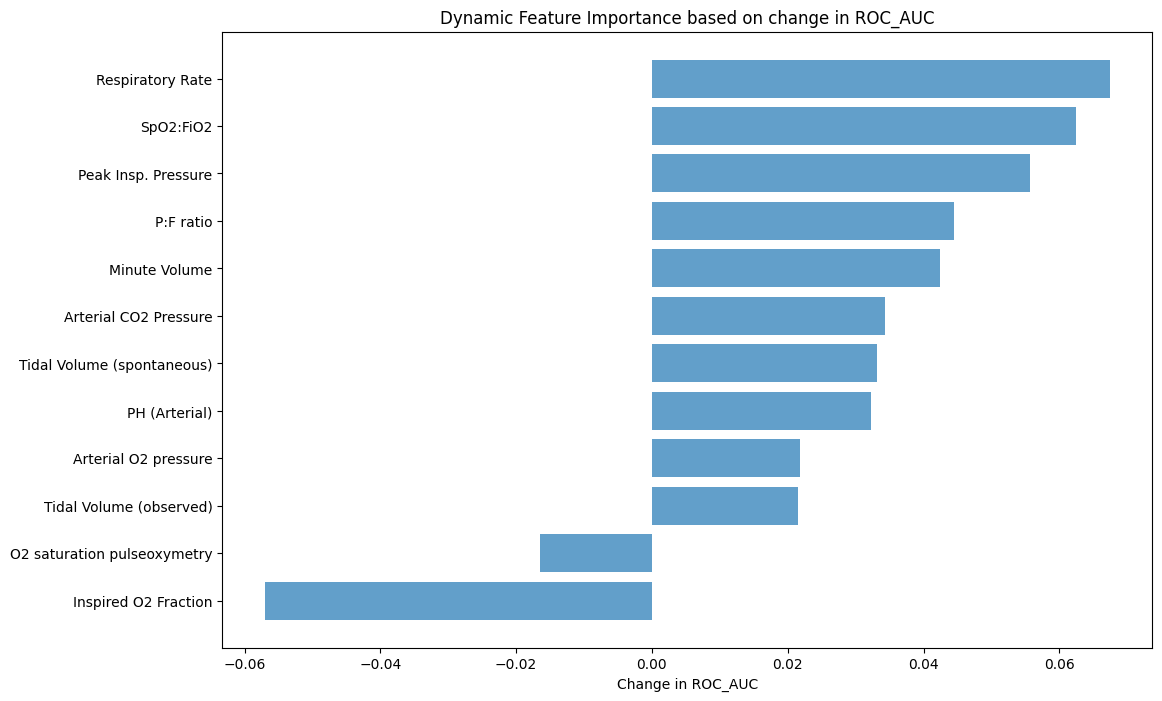

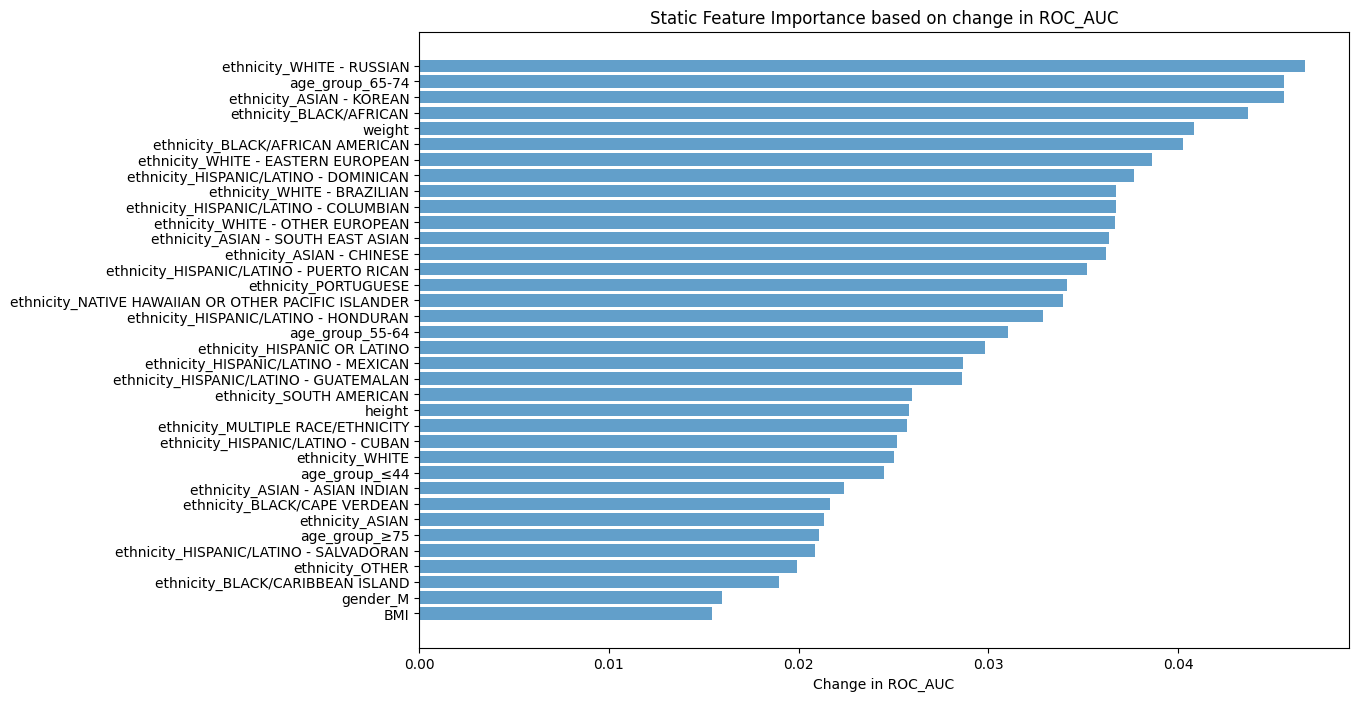

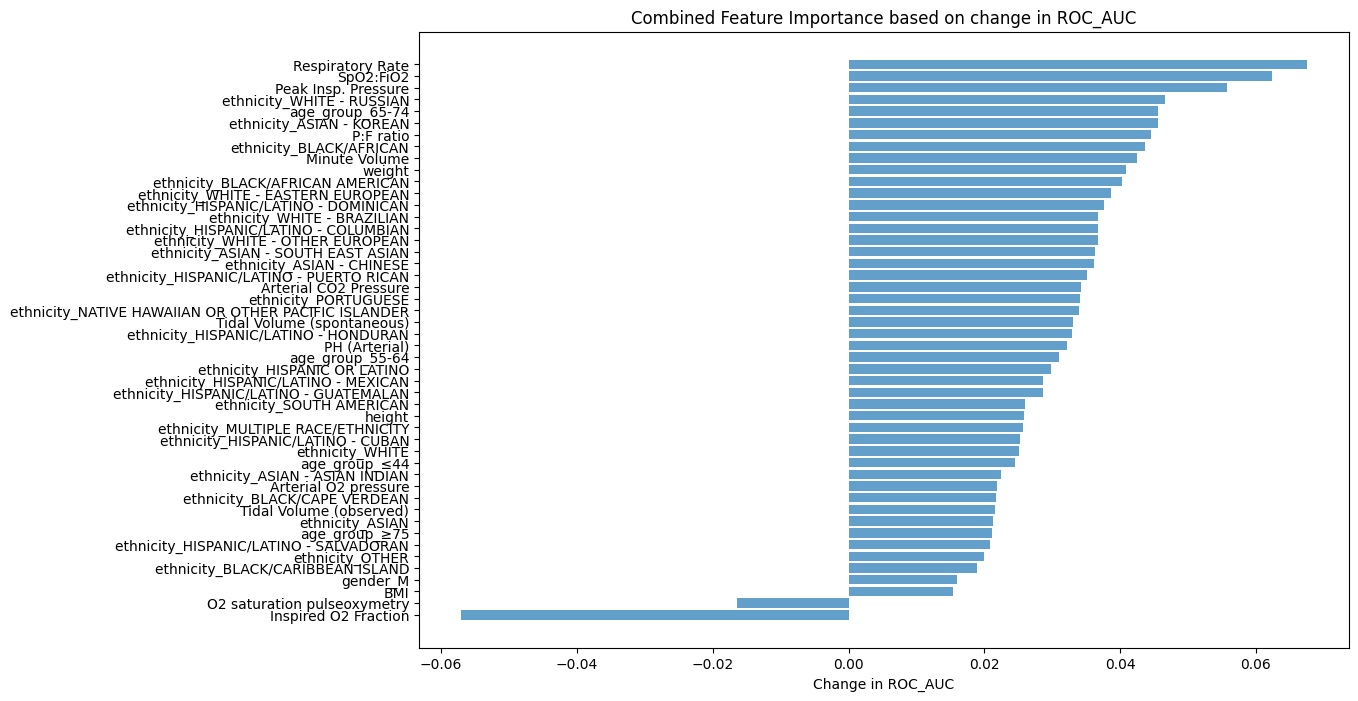

In [ ]:
# Run feature ablation
feature_importances_exp_2 = feature_ablation_with_names(train_sequences, train_static, train_labels, test_sequences, test_static, test_labels, final_model, best_hyperparams_exp_2, device, dynamic_feature_names, static_feature_names)

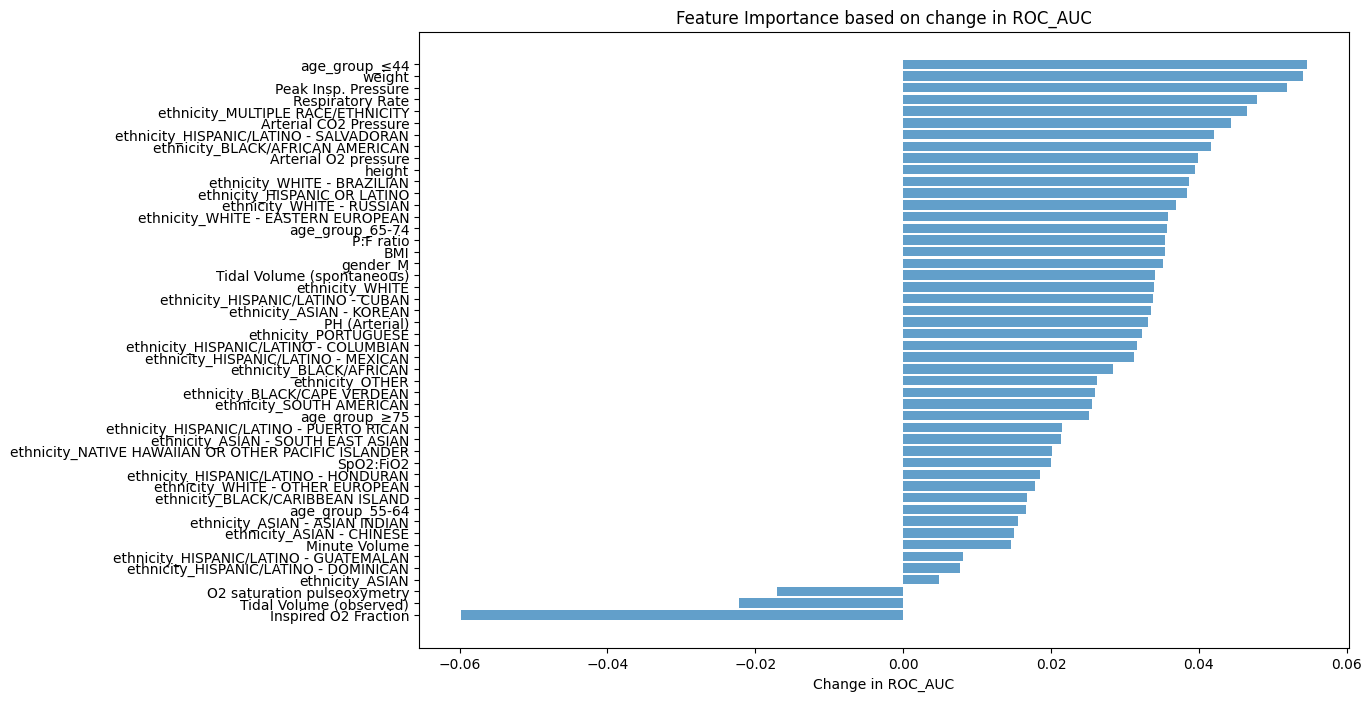

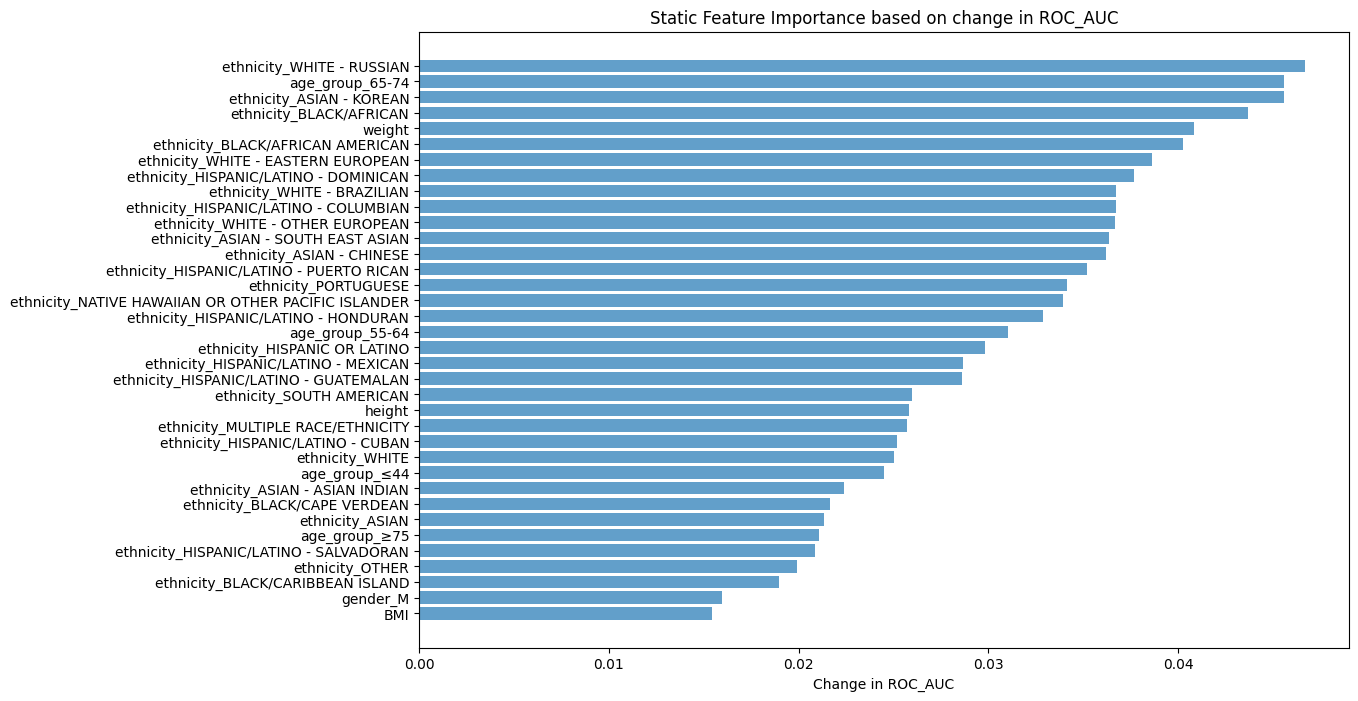

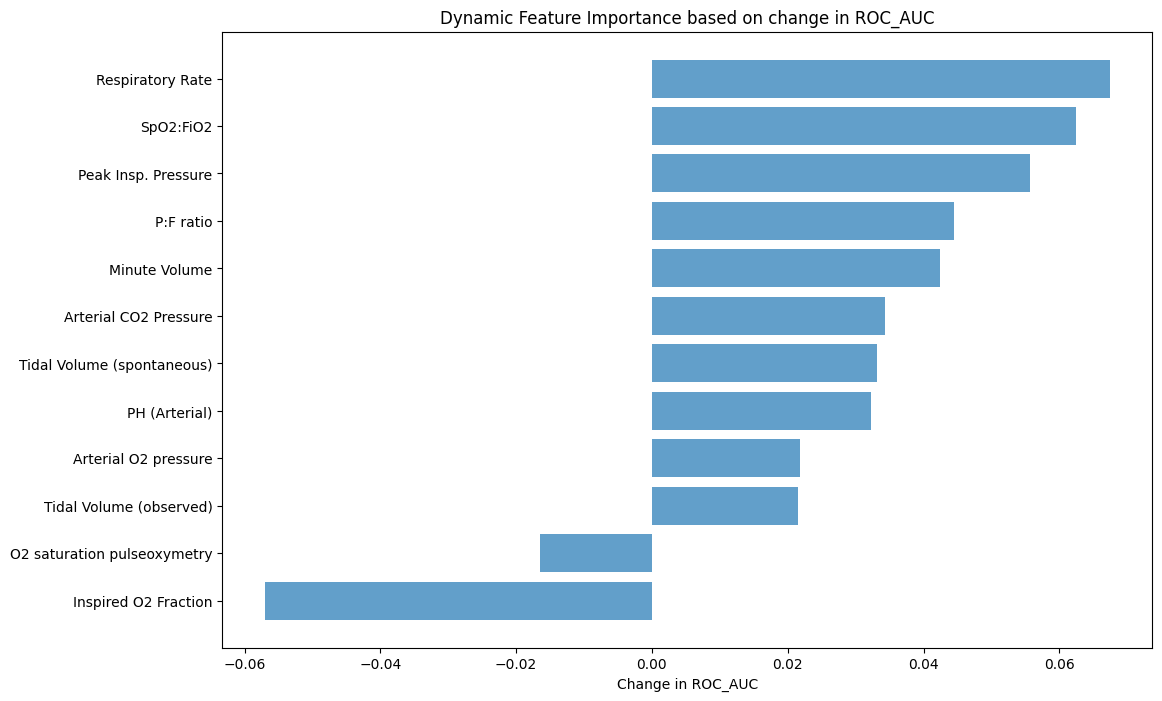

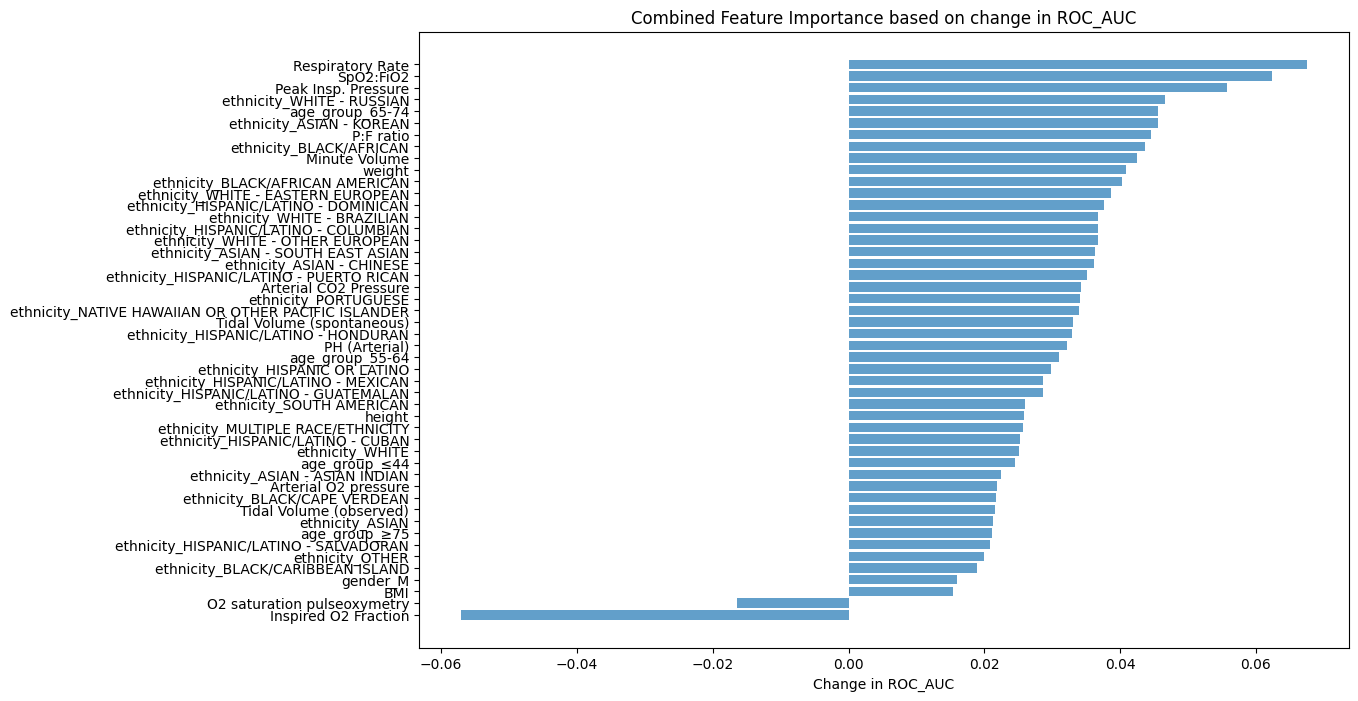

SaO2 and FiO2 are one again the most important features as with the dynamic model.